# Stopping Criteria for Gradient Descent

Controlling optimization through explicit termination rules.

## Objective

Demonstrate how different stopping criteria affect Gradient Descent behavior
under stable and well-conditioned optimization dynamics.

The goal is to make stopping behavior observable and interpretable,
not to induce numerical instability.

## Scope

This notebook focuses on:
* Maximum iteration limits
* Gradient norm–based stopping
* Loss improvement–based stopping
* Operational interpretation of stopping behavior

## Out of scope

This notebook explicitly excludes:
* Early stopping with validation data
* Learning rate schedules
* Adaptive optimizers
* Regularization effects

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Data-generating process

A simple linear relationship with additive noise is used.
No feature scaling is applied in order to keep optimization
dynamics stable and interpretable.

This setup reflects typical well-conditioned production scenarios.

In [2]:
X = np.linspace(0, 10, 50)
y = 3.0 * X + 5.0 + np.random.normal(0, 2, size=len(X))

## Loss function and gradients

Mean Squared Error is used as the loss function.
Gradients are implemented analytically to keep all dynamics explicit.

In [3]:
def mse_loss(w, b, X, y):
    y_pred = w * X + b
    return np.mean((y - y_pred) ** 2)

def mse_gradients(w, b, X, y):
    y_pred = w * X + b
    dw = -2 * np.mean(X * (y - y_pred))
    db = -2 * np.mean(y - y_pred)
    return dw, db

## Baseline optimization configuration

A stable learning rate is selected so that observed differences
are caused by stopping criteria rather than numerical instability.

In [4]:
learning_rate = 1e-2
max_iterations = 500

## Stopping criteria implementations

Each stopping function returns:
* The loss trajectory
* The number of iterations executed

This makes stopping behavior explicit and comparable.

In [5]:
def run_gd_with_gradient_stop(X, y, lr, max_iters, grad_tol):
    w, b = 0.0, 0.0
    loss_history = []

    for i in range(max_iters):
        dw, db = mse_gradients(w, b, X, y)
        grad_norm = np.sqrt(dw**2 + db**2)

        w -= lr * dw
        b -= lr * db
        loss_history.append(mse_loss(w, b, X, y))

        if grad_norm < grad_tol:
            return loss_history, i + 1

    return loss_history, max_iters

In [6]:
def run_gd_with_loss_stop(X, y, lr, max_iters, loss_tol):
    w, b = 0.0, 0.0
    loss_history = []

    prev_loss = None

    for i in range(max_iters):
        dw, db = mse_gradients(w, b, X, y)
        w -= lr * dw
        b -= lr * db

        loss = mse_loss(w, b, X, y)
        loss_history.append(loss)

        if prev_loss is not None and abs(prev_loss - loss) < loss_tol:
            return loss_history, i + 1

        prev_loss = loss

    return loss_history, max_iters

## Experiment execution

Three stopping regimes are evaluated under identical dynamics:
* Maximum iterations only
* Gradient norm threshold
* Loss improvement threshold

In [7]:
loss_max, it_max = run_gd_with_gradient_stop(
    X, y, learning_rate, max_iterations, grad_tol=0.0
)

loss_grad, it_grad = run_gd_with_gradient_stop(
    X, y, learning_rate, max_iterations, grad_tol=1e-3
)

loss_loss, it_loss = run_gd_with_loss_stop(
    X, y, learning_rate, max_iterations, loss_tol=1e-6
)

## Loss trajectories

Loss curves show how different stopping criteria terminate
optimization at different points under the same dynamics.

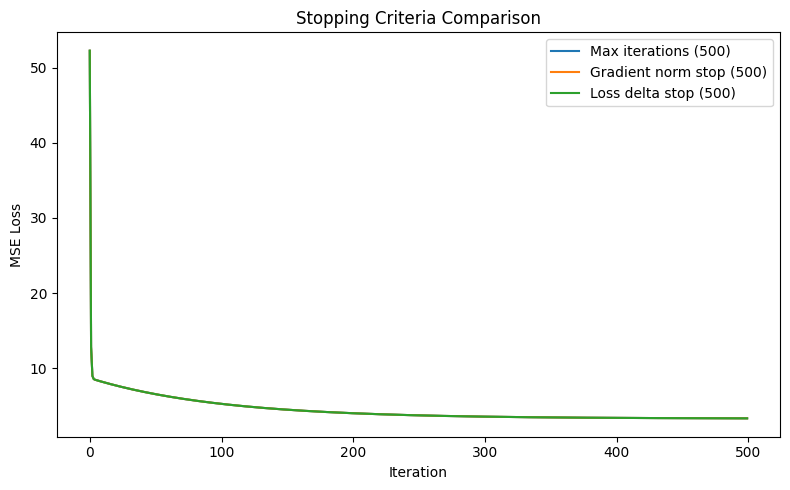

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(loss_max, label=f"Max iterations ({it_max})")
plt.plot(loss_grad, label=f"Gradient norm stop ({it_grad})")
plt.plot(loss_loss, label=f"Loss delta stop ({it_loss})")

plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Stopping Criteria Comparison")
plt.legend()
plt.tight_layout()
plt.show()

## Iterations until stopping

Iteration count is a primary operational signal when comparing
stopping criteria in real systems.

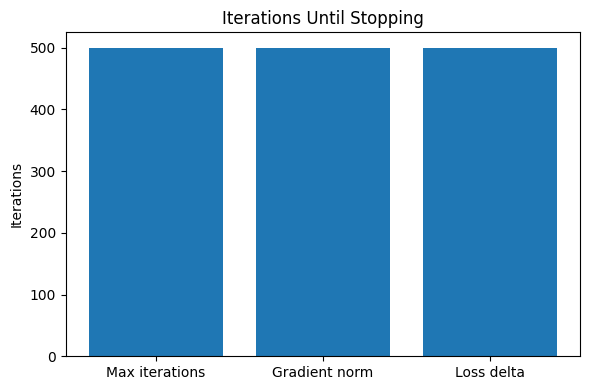

In [9]:
plt.figure(figsize=(6, 4))
plt.bar(
    ["Max iterations", "Gradient norm", "Loss delta"],
    [it_max, it_grad, it_loss]
)
plt.ylabel("Iterations")
plt.title("Iterations Until Stopping")
plt.tight_layout()
plt.show()

## Interpretation

Under stable and well-conditioned optimization dynamics,
gradient-norm and loss-improvement criteria may not trigger
before a predefined iteration budget is reached.

In such cases, different stopping rules behave equivalently.

## Engineering takeaway

Stopping criteria are safety mechanisms, not guarantees of early termination.

In well-conditioned problems, multiple criteria may agree,
and a maximum iteration cap often serves as the primary control.